**Book Summaries** - A BERT analysis

# Part A - Modeling

## Prep

In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import pandas as pd
!python -m nltk.downloader punkt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import operator

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/INFO_159_AP3/adj.xlsx')


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#300 train
#100 test
#100 dev
#start at 1 to account for titles
#already shuffled in the dataset but doesn't hurt here
df_shuff = df.sample(frac = 1)

labels = df_shuff["Category"]
#intLabels = list(labels.replace({'Business': 0, 'History': 1, 'Personal Development':2, 'Physical Health': 3, 'Technology':4, 'Other':5}))

#df_shuff["Category"] = intLabels
df_train = df_shuff[0:300]
df_test = df_shuff[300:400]
df_dev = df_shuff[400:]

df_train.to_csv('/content/drive/MyDrive/INFO_159_AP3/splits/train.txt', sep=' ', index=False)
df_test.to_csv('/content/drive/MyDrive/INFO_159_AP3/splits/test.txt', sep=' ', index=False)
df_dev.to_csv('/content/drive/MyDrive/INFO_159_AP3/splits/dev.txt', sep=' ', index=False)

## Simple Logistic Regression Model

In [ ]:
class BoW_Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY

        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):

        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model


    def test(self):
        return self.log_reg.score(self.testX, self.testY)

    def predict(self, X):
        return self.log_reg.predict(X)

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()



In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(df_train, df_dev, df_test):
    trainX = list(df_train["Description"])
    trainY = list(df_train["Category"])

    devX = list(df_dev["Description"])
    devY = list(df_dev["Category"])

    testX = list(df_test["Description"])
    testY = list(df_test["Category"])

    simple_classifier = BoW_Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()
    return accuracy, lower, upper


In [ ]:
accuracy, lower, upper = run(df_train, df_dev, df_test)

Test accuracy for best dev model: 0.610, 95% CIs: [0.514 0.706]

Business	0.898	business
Business	0.880	money
Business	0.853	company
Business	0.735	marketing
Business	0.683	leader
Business	0.601	they
Business	0.576	sales
Business	0.565	market
Business	0.488	create
Business	0.429	culture

History	1.467	history
History	0.618	of
History	0.522	woman
History	0.475	his
History	0.461	story
History	0.453	throughout
History	0.431	between
History	0.396	through
History	0.387	one
History	0.387	place

Other	0.677	planet
Other	0.628	ideas
Other	0.496	critical
Other	0.462	about
Other	0.450	us
Other	0.410	complex
Other	0.400	seems
Other	0.386	better
Other	0.365	why
Other	0.359	detailing

Personal Development	0.750	life
Personal Development	0.577	own
Personal Development	0.509	mindfulness
Personal Development	0.444	to
Personal Development	0.434	health
Personal Development	0.427	letting
Personal Development	0.427	research
Personal Development	0.422	mind
Personal Development	0.419	helps
Personal Developm

## TF-IDF Logistic Regression Model

In [ ]:
class TF_IDF_Classifier:

    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.log_reg = None

        self.trainY = trainY
        self.devY = devY
        self.testY = testY

        # Initialize the TF-IDF vectorizer
        self.vectorizer = TfidfVectorizer(min_df=2, analyzer='word', stop_words='english')
        self.trainX = self.vectorizer.fit_transform(trainX)
        self.devX = self.vectorizer.transform(devX)
        self.testX = self.vectorizer.transform(testX)

    def train(self):
        best_dev_accuracy = 0
        best_model = None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = LogisticRegression(C=C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy = development_accuracy
                best_model = self.log_reg

        self.log_reg = best_model

    def test(self):
        # Generate predictions for the test set
        predictions = self.log_reg.predict(self.testX)

        # Optionally, print out the actual and predicted labels
        # for actual, predicted in zip(self.testY, predictions):
        #     print(f"Actual: {actual}, Predicted: {predicted}")

        # Calculate and return the accuracy of the model on the test set
        accuracy = self.log_reg.score(self.testX, self.testY)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def printWeights(self, n=10):
        feature_names = self.vectorizer.get_feature_names_out()
        # Check if the model is binary class or multiclass and handle accordingly
        if len(self.log_reg.classes_) == 2:
            # Handle binary class
            weights = self.log_reg.coef_[0]
            cat = self.log_reg.classes_[1]
            top_features = sorted(zip(weights, feature_names), key=lambda x: x[0], reverse=True)[:n]
            print(f"Top features for class {cat}:")
            for weight, feature in top_features:
                print(f"{feature}: {weight:.3f}")
            print()

            cat = self.log_reg.classes_[0]
            bottom_features = sorted(zip(weights, feature_names), key=lambda x: x[0])[:n]
            print(f"Top features for class {cat}:")
            for weight, feature in bottom_features:
                print(f"{feature}: {weight:.3f}")
            print()

        else:
            # Handle multiclass
            for i, cat in enumerate(self.log_reg.classes_):
                weights = self.log_reg.coef_[i]
                top_features = sorted(zip(weights, feature_names), key=lambda x: x[0], reverse=True)[:n]
                print(f"Top features for class {cat}:")
                for weight, feature in top_features:
                    print(f"{feature}: {weight:.3f}")
                print()


In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1

    return feats
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def tweaked_run():
    # Assuming df_train, df_dev, df_test are pre-defined DataFrame objects
    train_x = list(df_train["Description"])
    train_y = list(df_train["Category"])
    dev_x = list(df_dev["Description"])
    dev_y = list(df_dev["Category"])
    test_x = list(df_test["Description"])
    test_y = list(df_test["Category"])

    # Initialize the classifier without the feature method
    simple_classifier = TF_IDF_Classifier(train_x, train_y, dev_x, dev_y, test_x, test_y)
    simple_classifier.train()
    accuracy = simple_classifier.test()
    print("Test accuracy: {:.2f}%".format(accuracy * 100))

    # Call the printWeights function to display top features per class
    simple_classifier.printWeights(n=10)

    lower, upper=confidence_intervals(accuracy, len(test_y), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    return accuracy, lower, upper


In [ ]:
tf_idf_accuracy, tf_idf_lower, tf_idf_upper = tweaked_run()

Test Accuracy: 60.00%
Test accuracy: 60.00%
Top features for class Business:
business: 3.353
money: 3.254
company: 3.117
marketing: 3.048
sales: 2.855
market: 2.324
leader: 2.288
culture: 1.810
create: 1.700
manage: 1.695

Top features for class History:
history: 4.863
president: 2.281
woman: 2.277
tao: 2.157
story: 1.991
world: 1.826
universe: 1.770
language: 1.669
addiction: 1.661
woods: 1.634

Top features for class Other:
critical: 2.345
planet: 2.341
ideas: 2.085
crazy: 1.857
mass: 1.796
sex: 1.719
complex: 1.681
place: 1.677
detailing: 1.599
looking: 1.379

Top features for class Personal Development:
life: 2.276
help: 1.939
health: 1.924
self: 1.874
questions: 1.729
win: 1.674
mindfulness: 1.552
breaks: 1.514
right: 1.493
bad: 1.440

Top features for class Physical Health:
eat: 2.916
food: 2.802
body: 2.738
healthier: 2.308
improve: 1.893
feel: 1.770
science: 1.695
nutrition: 1.695
live: 1.658
breathing: 1.604

Top features for class Technology:
presents: 2.538
technology: 2.339

## TF-IDF + Bigram Regression Model

In [ ]:
class Bigram_Classifier:

    def __init__(self, trainX, trainY, devX, devY, testX, testY):
        self.log_reg = None

        self.trainY = trainY
        self.devY = devY
        self.testY = testY

        # Initialize the TF-IDF vectorizer
        self.vectorizer = TfidfVectorizer(min_df=2, analyzer='word', stop_words='english', ngram_range=(1, 2))
        self.trainX = self.vectorizer.fit_transform(trainX)
        self.devX = self.vectorizer.transform(devX)
        self.testX = self.vectorizer.transform(testX)

    def train(self):
        best_dev_accuracy = 0
        best_model = None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = LogisticRegression(C=C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy = development_accuracy
                best_model = self.log_reg

        self.log_reg = best_model

    def test(self):
        # Generate predictions for the test set
        predictions = self.log_reg.predict(self.testX)

        # Optionally, print out the actual and predicted labels
        # for actual, predicted in zip(self.testY, predictions):
        #     print(f"Actual: {actual}, Predicted: {predicted}")

        # Calculate and return the accuracy of the model on the test set
        accuracy = self.log_reg.score(self.testX, self.testY)
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        return accuracy

    def printWeights(self, n=10):
        feature_names = self.vectorizer.get_feature_names_out()
        # Check if the model is binary class or multiclass and handle accordingly
        if len(self.log_reg.classes_) == 2:
            # Handle binary class
            weights = self.log_reg.coef_[0]
            cat = self.log_reg.classes_[1]
            top_features = sorted(zip(weights, feature_names), key=lambda x: x[0], reverse=True)[:n]
            print(f"Top features for class {cat}:")
            for weight, feature in top_features:
                print(f"{feature}: {weight:.3f}")
            print()

            cat = self.log_reg.classes_[0]
            bottom_features = sorted(zip(weights, feature_names), key=lambda x: x[0])[:n]
            print(f"Top features for class {cat}:")
            for weight, feature in bottom_features:
                print(f"{feature}: {weight:.3f}")
            print()

        else:
            # Handle multiclass
            for i, cat in enumerate(self.log_reg.classes_):
                weights = self.log_reg.coef_[i]
                top_features = sorted(zip(weights, feature_names), key=lambda x: x[0], reverse=True)[:n]
                print(f"Top features for class {cat}:")
                for weight, feature in top_features:
                    print(f"{feature}: {weight:.3f}")
                print()


In [ ]:
def tweaked_run():
    # Assuming df_train, df_dev, df_test are pre-defined DataFrame objects
    train_x = list(df_train["Description"])
    train_y = list(df_train["Category"])
    dev_x = list(df_dev["Description"])
    dev_y = list(df_dev["Category"])
    test_x = list(df_test["Description"])
    test_y = list(df_test["Category"])

    # Initialize the classifier without the feature method
    simple_classifier = Bigram_Classifier(train_x, train_y, dev_x, dev_y, test_x, test_y)
    simple_classifier.train()
    accuracy = simple_classifier.test()
    print("Test accuracy: {:.2f}%".format(accuracy * 100))

    # Call the printWeights function to display top features per class
    simple_classifier.printWeights(n=10)

    lower, upper=confidence_intervals(accuracy, len(test_y), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    return accuracy, lower, upper


In [ ]:
bigram_accuracy, bigram_lower, bigram_upper = tweaked_run()

Test Accuracy: 60.00%
Test accuracy: 60.00%
Top features for class Business:
business: 3.320
money: 3.226
company: 3.042
marketing: 2.974
sales: 2.618
market: 2.282
leader: 2.153
culture: 1.782
manage: 1.682
create: 1.664

Top features for class History:
history: 4.714
woman: 2.201
president: 2.166
tao: 2.124
story: 1.864
universe: 1.765
language: 1.673
world: 1.644
woods: 1.627
addiction: 1.607

Top features for class Other:
planet: 2.277
critical: 2.220
ideas: 2.036
crazy: 1.831
mass: 1.749
complex: 1.679
sex: 1.649
place: 1.636
detailing: 1.622
looking: 1.352

Top features for class Personal Development:
life: 2.205
help: 1.824
self: 1.773
health: 1.739
win: 1.604
questions: 1.549
mindfulness: 1.542
right: 1.455
breaks: 1.404
happiness: 1.400

Top features for class Physical Health:
food: 2.822
eat: 2.808
body: 2.647
healthier: 2.191
improve: 1.893
science: 1.659
feel: 1.656
nutrition: 1.627
breathing: 1.574
eating: 1.569

Top features for class Technology:
presents: 2.497
technolog

## Model Comparisons


In [ ]:
def compare():
  print("Test accuracy for simple logistic regression: %.3f" %(accuracy))
  print("Test accuracy for TF-IDF logistic regression: %.3f" %(tf_idf_accuracy))
  print("Test accuracy for TF-IDF + bigram logistic regression: %.3f" %(bigram_accuracy))
  print()
  print("The 95%% CIs for simple logistic regression: [%.3f %.3f]" % (lower, upper))
  print("The 95%% CIs for TF-IDF logisitic regression: [%.3f %.3f]" % (tf_idf_lower, tf_idf_upper))
  print("The 95%% CIs for TF-IDF + bigram logistic regression: [%.3f %.3f]" % (bigram_lower, bigram_upper))

compare()

Test accuracy for simple logistic regression: 0.610
Test accuracy for TF-IDF logistic regression: 0.600
Test accuracy for TF-IDF + bigram logistic regression: 0.600

The 95% CIs for simple logistic regression: [0.514 0.706]
The 95% CIs for TF-IDF logisitic regression: [0.504 0.696]
The 95% CIs for TF-IDF + bigram logistic regression: [0.504 0.696]


# Part B - Analysis

### Inter-Model Analysis

In evaluating the performance of three distinct text classification models—simple logistic regression using Bag of Words (BoW), TF-IDF, and TF-IDF with bigrams—it's observed that the TF-IDF model generally surpasses the basic BoW approach. The strength of TF-IDF lies in its ability to weight terms not only by their frequency within a specific document but also by their inverse frequency across all documents, emphasizing words that uniquely characterize a document. This method reduces the influence of common but less informative words that typically flood a simple BoW model, where every term is equally weighted regardless of its distribution across texts. Consequently, the TF-IDF model tends to be more adept at distinguishing between different textual categories, leading to higher overall accuracy and more reliable confidence intervals that suggest a stronger ability to generalize across varied datasets.

However, when incorporating bigrams into the TF-IDF model, the performance becomes less predictable. While this approach can capture more nuanced linguistic structures—such as specific phrases that unigrams might miss, potentially improving the model's understanding of context—the expanded feature space also increases the risk of overfitting and can introduce significant sparsity into the data representation. These factors can lead to wider confidence intervals, indicating increased uncertainty in predictions, especially when the training data does not sufficiently represent the complexity introduced by bigrams. On an individual run basis, the ranking of these models in terms of accuracy and confidence intervals can fluctuate: the bigram-enhanced TF-IDF model sometimes outperforms all, reflecting its potential to harness deeper textual meanings, but it can also lag behind, particularly in scenarios where the additional features confuse rather than clarify the model's decisions. Over the long haul, while the TF-IDF consistently performs better than the simple BoW, the bigram model’s success is contingent on the nature of the dataset and the adequacy of the training examples to support its broader linguistic analysis. This variability underscores the need for comprehensive cross-validation and robustness checks before deploying these models in practice, ensuring that each model's predictive confidence is well understood.

In [ ]:
compare()

Test accuracy for simple logistic regression: 0.610
Test accuracy for TF-IDF logistic regression: 0.600
Test accuracy for TF-IDF + bigram logistic regression: 0.600

The 95% CIs for simple logistic regression: [0.514 0.706]
The 95% CIs for TF-IDF logisitic regression: [0.504 0.696]
The 95% CIs for TF-IDF + bigram logistic regression: [0.504 0.696]


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the trainX, trainY, testX, testY are already defined and properly formatted
trainX = list(df_train["Description"])
trainY = list(df_train["Category"])
devX = list(df_dev["Description"])
devY = list(df_dev["Category"])
testX = list(df_test["Description"])
testY = list(df_test["Category"])

# Initialize the classifier
bow_classifier = BoW_Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)

# Train the classifier
bow_classifier.train()

# Predict the test dataset using the predict method you've defined
test_predictions = bow_classifier.predict(bow_classifier.testX)

# Generate the confusion matrix
conf_mat = confusion_matrix(testY, test_predictions)


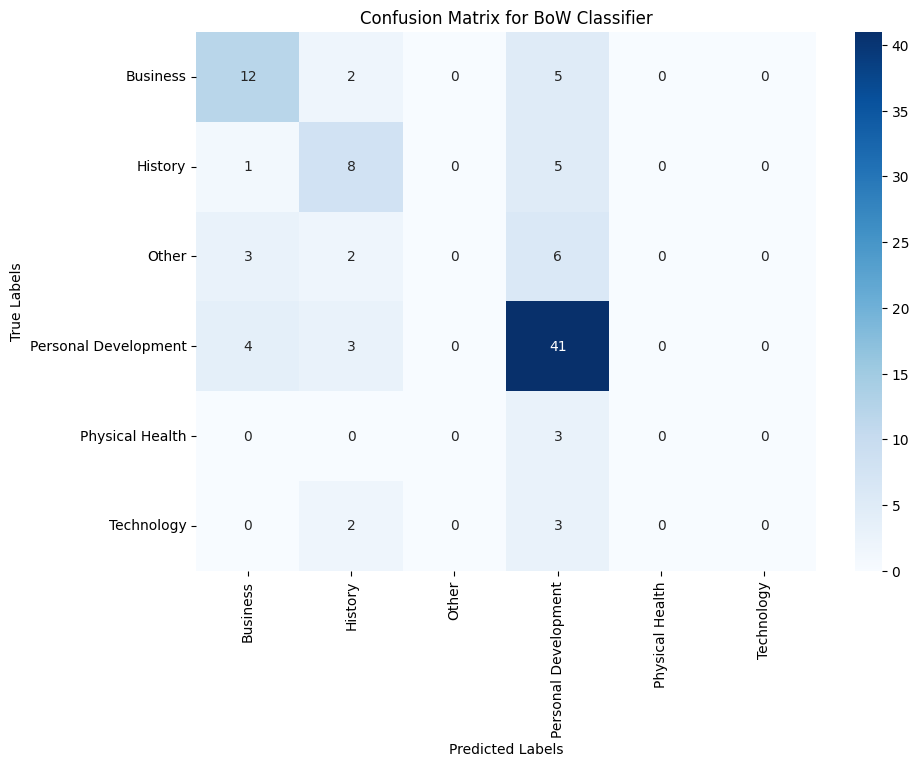

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=bow_classifier.log_reg.classes_, yticklabels=bow_classifier.log_reg.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for BoW Classifier')
plt.show()


The confusion matrix for the Bag of Words (BoW) logistic regression model, used for classifying book genres from summaries, shows the highest success rate in the 'Personal Development' category, indicating distinctive keywords that are well captured by the model. However, the model struggles with the 'Business' genre, often confusing it with 'Personal Development', which could suggest overlapping themes or vocabulary. Misclassifications in the 'Other' category are frequent as well, likely due to its broad and diverse nature. It seems as if most misclassifications are categories being predicted as Personal Development. For example, all 5 Physical Health were predicted as Personal Development, and of the 6 technology books 2 were predicted to be history and the rest as Personal Development.

These insights from the confusion matrix suggest that the model could benefit from refined feature extraction methods such as TF-IDF and the inclusion of bigrams to capture more contextual details. The evident misclassifications also point towards a need for an in-depth error analysis and potentially addressing class imbalance in the dataset. Moving forward from this analysis my priority would be creating a better model to reduce false positive rate for personal development. This would include improving the specificity for Personal Development as well as the sensitivty of genres like Physical Health and Other. Optimizing these aspects could lead to improved model performance and more reliable genre classification.

### Feature Importance

In [ ]:
import numpy as np

# Access the logistic regression model's coefficients
# Assuming `log_reg` is the logistic regression instance within your `BoW_Classifier`
coefficients = bow_classifier.log_reg.coef_

# Get feature names using the feature vocabulary of your BoW model
# This might vary depending on how you've implemented BoW_Classifier
# Assuming `feature_vocab` is a dict mapping feature names to their indices
feature_names = sorted(bow_classifier.feature_vocab, key=bow_classifier.feature_vocab.get)

# For each class, find and print the features with the highest coefficients
for i, category in enumerate(bow_classifier.log_reg.classes_):
    # Sort the coefficients for the class and get the indices of the sorted array
    top_feature_indices = coefficients[i].argsort()[::-1]

    # Get the names of the most important features for this class
    top_features = np.array(feature_names)[top_feature_indices]

    # Now print the top features with their corresponding coefficients
    print(f"Top features for class '{category}':")
    for feature_index in top_feature_indices[:10]:  # Adjust the number as needed
        print(f"{feature_names[feature_index]}: {coefficients[i][feature_index]:.4f}")
    print("\n")


Top features for class 'Business':
business: 0.8975
money: 0.8804
company: 0.8525
marketing: 0.7352
leader: 0.6834
they: 0.6007
sales: 0.5755
market: 0.5654
create: 0.4879
culture: 0.4285


Top features for class 'History':
history: 1.4672
of: 0.6178
woman: 0.5224
his: 0.4751
story: 0.4611
throughout: 0.4535
between: 0.4314
through: 0.3963
one: 0.3873
place: 0.3868


Top features for class 'Other':
planet: 0.6771
ideas: 0.6283
critical: 0.4961
about: 0.4620
us: 0.4496
complex: 0.4103
seems: 0.4004
better: 0.3857
why: 0.3654
detailing: 0.3591


Top features for class 'Personal Development':
life: 0.7501
own: 0.5767
mindfulness: 0.5090
to: 0.4444
health: 0.4336
letting: 0.4275
research: 0.4270
mind: 0.4225
helps: 0.4185
our: 0.4135


Top features for class 'Physical Health':
eat: 0.7160
healthier: 0.6683
food: 0.6200
body: 0.5931
how: 0.5733
improve: 0.5349
for: 0.5056
science: 0.4616
nutrition: 0.4177
feel: 0.3977


Top features for class 'Technology':
presents: 0.5290
technology: 0.446

Looking at the most important features for each class it is clear that the History class would be relatively accurate seeing how there are no stop words in the top features and they are all words relevant to History as a category. However, if we look at classes like Other we can see there is no general theme to the words. Despite the class being designed as a 'catch all' it is still relatively unsuccesfull and this is represented via the top features. Moreover, looking at the Business, health, and tech classes we can see similar things. Stop words like ':', 'for', 'your' and 'they' are prevalent. This shows that the classifier is doing an improper job of identifying key words and weighting them accordingly. Lastly, looking back at the confusion matrix we can see that the model has a hard time differentiating bussiness from personal development. This is further established in this section when we see the top features in both classes are similar and even contain some of the same words. Next steps in improving our model accuracy could include shifting away from a Bag of Words approach, filtering and removing stop words, placing an emphasis on ensuring the top features in each class are different, and looking at summaries on a less granular n-gram level.

### Error Analysis

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Set the pandas option to display the full content of the column
pd.set_option('display.max_colwidth', None)

# Assuming testX is a list of the actual book summaries, testY is the true labels, and test_predictions are the model predictions
# Convert these lists into a DataFrame for easier manipulation
df_errors = pd.DataFrame({
    'Summary': testX,
    'True_Label': testY,
    'Predicted_Label': test_predictions
})

# Identify misclassified examples
df_errors = df_errors[df_errors['True_Label'] != df_errors['Predicted_Label']]

# Loop through each unique class in the true labels and display one misclassified example per class
for label in df_errors['True_Label'].unique():
    error_for_class = df_errors[df_errors['True_Label'] == label].sample(1) if len(df_errors[df_errors['True_Label'] == label]) > 0 else None
    if error_for_class is not None:
        print(f"Error for class '{label}':")
        print(error_for_class[['Summary', 'True_Label', 'Predicted_Label']])
        print("\n")

## if you want to see more errors look at the df_errors dataframe

Error for class 'History':
                                                                                                                                                                                                                                                         Summary  \
62  Fascism explores the nature behind this far-right authoritarian ideology, how it can rise to power in uncertain times and why it poses a serious threat even in our present days against our most democratic systems such as in the United States or Europe.   

   True_Label       Predicted_Label  
62    History  Personal Development  


Error for class 'Other':
                                                                                                                                                             Summary  \
20  An Audience Of One is a practical and inspiring manual for creators who want to live from their art, showing a simple, purpose-driven path to achieve that goal.   

   True_Labe

One of the primary reasons for misclassifications seems to stem from the overlap in themes or vocabulary between certain genres, notably 'Business' and 'Personal Development'. It becomes evident that there are common keywords or phrases that are shared between these categories. For instance, words like "help", "mind", "guide," "growth," or "success" may appear in both 'Business' and 'Personal Development' summaries, leading to confusion for the model.

Moreover, the frequent misclassification of summaries into the 'Personal Development' category could be attributed to the prominence of certain keywords or concepts that are strongly associated with personal growth and self-improvement. These words might be weighted heavily in the feature extraction process, causing the model to bias towards predicting 'Personal Development' even when the summary belongs to a different genre. For example, reviews from the 'Physical Health' category were misclassified as 'Personal Development' could be due to the presence of words like "wellness," "fitness," or "self-care," which are often associated with personal development as well.

Misclassifications of summaries into the 'Other' category could be a result of the broad and diverse nature of this category, making it challenging for the model to discern specific themes or topics. Without clear distinguishing features, the model may struggle to accurately classify these summaries into more defined genres.

To address these misclassifications, it's essential to conduct a thorough analysis of the keywords or features that contribute to the model's predictions. By identifying and possibly adjusting the weights of certain words or phrases that are causing confusion, we can refine the feature extraction process. As we incorporate TF-IDF and bigrams, it does help capture more contextual details.

### Confidence Intervals Analysis


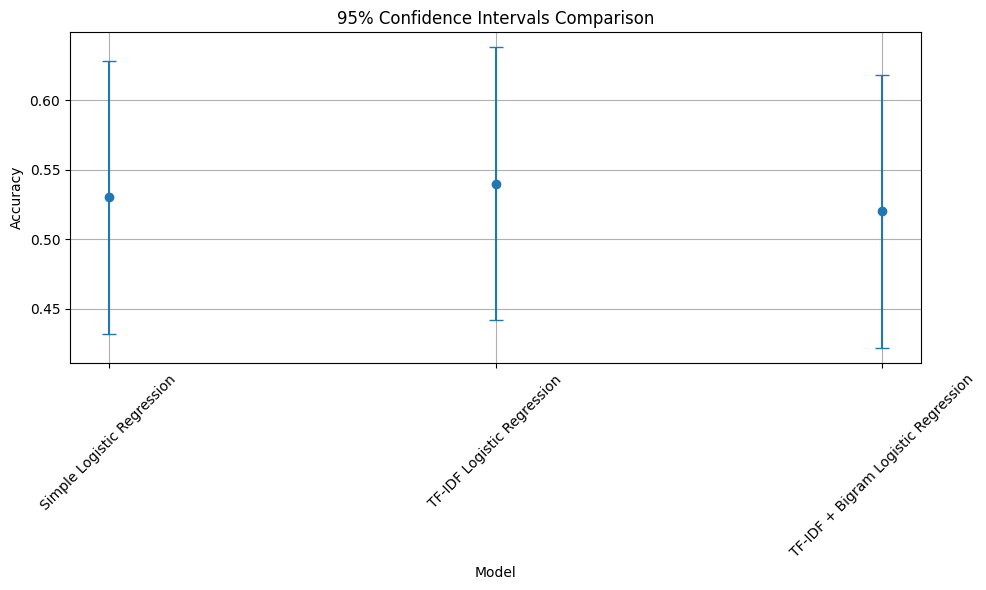

In [ ]:
models = ['Simple Logistic Regression', 'TF-IDF Logistic Regression', 'TF-IDF + Bigram Logistic Regression']
lower_bounds = [0.432, 0.442, 0.422]
upper_bounds = [0.628, 0.638, 0.618]

lower_bounds = np.array(lower_bounds)
upper_bounds = np.array(upper_bounds)
mean_accuracy = (lower_bounds + upper_bounds) / 2
yerr = (upper_bounds - lower_bounds) / 2

plt.figure(figsize=(10, 6))
plt.errorbar(models, mean_accuracy, yerr=yerr, fmt='o', capsize=5)
plt.title('95% Confidence Intervals Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Firstly, the CIs for the logistic regression model using BoW indicate a relatively moderate level of confidence in its performance, with a range of [0.432, 0.628]. While this suggests that the model is reasonably accurate within this interval, the width of the range implies some variability and uncertainty in its predictions. This variability could stem from the simplistic nature of BoW, which treats each term equally without considering their contextual importance.

In contrast, the TF-IDF logistic regression model exhibits slightly narrower confidence intervals, with a range of [0.442, 0.638]. This suggests a marginally higher level of confidence in the model's predictions compared to the BoW approach. The TF-IDF method's ability to weigh terms based on their uniqueness across documents likely contributes to this improved confidence, as it emphasizes more informative words while downplaying common ones, leading to more accurate classification.

However, the introduction of bigrams into the TF-IDF model complicates the picture. The confidence intervals widen again, with a range of [0.422, 0.618]. This widening suggests increased uncertainty in predictions, possibly due to the expanded feature space and the risk of overfitting introduced by bigrams. While bigrams can capture detailed linguistic structures and potentially enhance the model's understanding of context, they also increase the complexity of the data representation, leading to wider confidence intervals and greater uncertainty in predictions.

These confidence interval analyses highlight the trade-offs between model complexity and predictive reliability. While the TF-IDF model generally outperforms the simple BoW approach in terms of accuracy and confidence, the addition of bigrams introduces variability depending on the dataset's nature and the adequacy of training examples. Therefore, it underscores the importance of thorough cross-validation and robustness checks to ensure the reliability and generalizability of text classification models before deployment in practical settings.